In [115]:
import pandas as pd
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import utils

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
stemmer = PorterStemmer()

In [82]:
tdf = pd.read_csv('transcripts/transcripts.csv', index_col=0)
sdf = pd.read_csv('transcripts/speeches.csv', index_col=0)
# tdf = pd.read_csv('transcripts/transcripts_sents.csv', index_col=0)
# sdf = pd.read_csv('transcripts/speech_sents.csv', index_col=0)

In [83]:
sdf['tokens'] = sdf['text'].apply(lambda x: utils.process(x, stemmer=stemmer))

In [84]:
tdf['tokens'] = tdf['content'].apply(lambda x : utils.process(x, stemmer=stemmer)) 

In [85]:
texts = tdf['tokens'].tolist() + sdf['tokens'].tolist()

In [86]:
len(texts)

78564

In [87]:
dictionary = Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

### EVENTUALLY USE MORE SOPHISTICATED PROCEDURE TO SELECT NUMBER OF TOPICS

In [ ]:
def coherence_compare(corpus, start, stop, step):
    for i in range(start, stop, step):
        lda = LdaModel(corpus, i, id2word=dictionary, passes=1)
        cm = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary)
        print(cm.get_coherence())
coherence_compare(corpus, 2, 4, 3)

In [88]:
ldamodel = LdaModel(corpus, num_topics=40, id2word=dictionary, passes=10)

In [66]:
ldamodel.save('lda-40topics-111523')

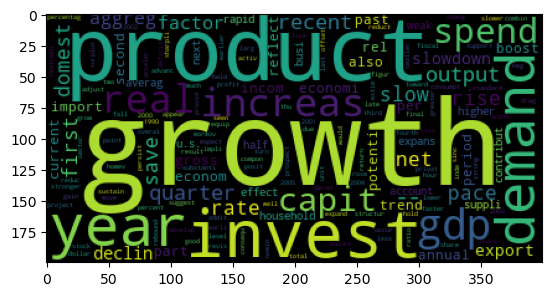

In [109]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(3, 200))))

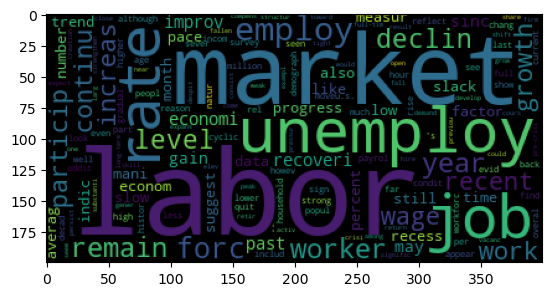

In [110]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(6, 200))))

In [93]:
ldamodel.show_topics(40)

[(0,
  '0.052*"``" + 0.047*"\'\'" + 0.031*"think" + 0.022*"n\'t" + 0.022*"--" + 0.015*"go" + 0.013*"\'s" + 0.010*"say" + 0.010*"us" + 0.010*"one"'),
 (1,
  '0.239*"2011" + 0.228*"2010" + 0.087*"mass" + 0.059*"chart" + 0.046*"fisher" + 0.022*"quick" + 0.021*"\'novemb" + 0.014*"mester" + 0.013*"fan" + 0.013*"pianalto"'),
 (2,
  '0.197*"reserv" + 0.190*"feder" + 0.046*"bank" + 0.028*"system" + 0.019*"board" + 0.017*"\'s" + 0.016*"fed" + 0.015*"oper" + 0.012*"market" + 0.009*"financ"'),
 (3,
  '0.073*"growth" + 0.047*"product" + 0.024*"invest" + 0.022*"year" + 0.019*"demand" + 0.016*"gdp" + 0.015*"increas" + 0.014*"real" + 0.012*"spend" + 0.011*"capit"'),
 (4,
  '0.251*"presid" + 0.173*"\'thank" + 0.093*"chairman" + 0.049*"laughter" + 0.038*"evan" + 0.032*"mr." + 0.014*"approv" + 0.013*"motion" + 0.012*"amen" + 0.012*"mr"'),
 (5,
  '0.394*"new" + 0.085*"york" + 0.036*"street" + 0.031*"2008" + 0.026*"sharehold" + 0.025*"wall" + 0.023*"act" + 0.023*"gse" + 0.019*"brother" + 0.018*"transfer"'

- Topic 0: Inflation
- Topic 5: Exchange rates
- Topic 6: Housing market
- Topic 12:
- Topic 13: The FFR
- Topic 14: Normalization
- Topic 15: Growth
- Topic 16: inflation
- Topic 17: banking/credit/lending
- Topic 19: interest rates
- Topic 21: the labor market
- Topic 22: data, modeling, measurement
- Topic 23: ?
- Topic 24: ?
- Topic 25: ?
- Topic 27: ?
- Topic 28: LOOK INTO THIS
- Topic 29: communication
- Topic 31: more general economic ?
- Topic 32: risk
- Topic 33: more banking, risk, firms, capital
- Topic 34: financial regulation and support
- Topic 35: the fed's balance sheet
- Topic 36: securities markets
- Topic 37: ecnomic growth (maybe plus some)
- Topic 39: the global economy

In [94]:
def get_topics(tokens):
    topic_probs = ldamodel[dictionary.doc2bow(tokens)]
    if len(topic_probs) > 0:
        max_prob = topic_probs[0][1]
        max_ind = 0
        for i in range(1, len(topic_probs)):
            if topic_probs[i][1] > max_prob:
                max_prob = topic_probs[i][1]
                max_ind = i
        return pd.Series([topic_probs[max_ind][0], max_prob], index=['topic', 'prob'])
    return pd.Series([None, None], index=['topic', 'prob'])

get_topics(tdf.loc[205].tokens)

topic    31.000000
prob      0.394183
dtype: float64

In [103]:
tdf.loc[200].condensed

'We could do zero.'

In [95]:
tdf[['topic','topic_prob']] = tdf.tokens.apply(get_topics)

In [106]:
sdf[['topic', 'topic_prob']] = sdf.tokens.apply(get_topics)

In [108]:
for item in sdf[sdf['topic'] == 6.0]['text'][:25]:
    print(item)

The economy has remained strong as the FOMC raised the federal funds rate, and recent data indicate that economic activity has accelerated with real gross domestic product (GDP) growing at a 4.9 percent annual rate in the third quarter. Consumer spending has also accelerated, and the housing sector appears to be continuing to rebound. The latest employment report showed a labor market with healthy job gains. Over the past year, labor force participation has improved with the average pace of job gains slowing somewhat, a sign that labor market supply and demand may be coming into better balance.
However, throughout the past few years, we have seen continued data revisions, with the most recent of these revisions reflecting significant changes to employment data. Job gains in prior months were revised lower, but average hourly earnings for the past 12 months were revised higher. The frequency and extent of data revisions make the task of predicting how the economy will evolve even more c

In [105]:
for item in tdf[tdf['topic'] == 6.0]['condensed'][:25]:
    print(item)

The emerging market economies, relative to us, still look more or less where they've been for the past five, six years?
Against that backdrop, what we saw was a still significantly improving labor market with payroll employment increasing by nearly 200,000 jobs per month, which is considerably faster than the demographic requirement to absorb the increase in the labor force. The unemployment rate was coming down.  You may not feel our pain, but we did.  I didn't know how to understand the world through that period if it were the case that we maintained an assumption that potential GDP growth was increasing at something like 13/4 percent, which by the way is where we think the "uncontaminated" estimate of potential GDP really is. We put the measurement in there, as Bill described, but as a matter of pragmatism and convenience, not as a matter of conviction.
Thank you, Madam Chair.  We face two significant puzzles in understanding the current macroeconomic situation.  The first is that l

In [111]:
for item in tdf[tdf['topic'] == 3.0]['condensed'][:25]:
    print(item)

Flat against the dollar for the remainder of the year, and then, after that, they allow it to again start appreciating at a very slow, around 2 percent, pace.
I've spoken about that in the past actually.  There has been some seasonality.  It has happened before--that some seasonal moves upward have occurred in the first part of the year.
Including the volume expansions?
It's everything. It's from a number of regions, and there's also a slowing in the domestic component.  Really, the growth in currency is slowing in all areas.
Capital accounts are becoming more important than current accounts?
I hesitate to attempt to do the arithmetic on the spot. My guess is that we would probably say that 10 percent is too large an estimate of the output gap in Japan, in part because a whole decade of largely reduced capital accumulation has had a bearing on the size of that gap. And with labor force growth essentially zero at this point, we see Japanese potential as radically different from what it 

In [112]:
for item in sdf[sdf['topic'] == 3.0]['text'][:25]:
    print(item)

Growth
To date, declining inflation has not come at the cost of meaningfully higher unemployment--a highly welcome development, but a historically unusual one. Healing of supply chains in conjunction with the rebalancing of demand and supply in the labor market has allowed disinflation without substantially weaker economic activity. Indeed, economic growth has consistently surprised to the upside this year, as most recently seen in the strong retail sales data released earlier this week. Forecasters generally expect gross domestic product to come in very strong for the third quarter before cooling off in the fourth quarter and next year. Still, the record suggests that a sustainable return to our 2 percent inflation goal is likely to require a period of below-trend growth and some further softening in labor market conditions.
Let's now dig into the recent economic data, starting with those on economic activity that help us get a handle on the strength of demand. Real gross domestic pro

In [114]:
path = "Loughran-McDonald_MasterDictionary_1993-2021.csv"

lm_df = pd.read_csv(path)

lm = {}

for i, row in lm_df.iterrows():
    # print(row)
    word = str(row['Word']).lower()
    if row['Negative'] != 0:
        lm[word] = -1
    if row['Positive'] != 0:
        lm[word] = 1

In [196]:
def sentscore(string):
    # tokens = process(string)
    total = 0
    tokens = [token.lower() for token in word_tokenize(str(string))]
    for token in tokens:
        # print(token)
        if token in lm:
            total += lm[token]
            # print(token)
            # print(lm[token])
    # print(total)
    # print(tokens)
    return total / len(tokens)

In [197]:
tdf['lm_sent'] = tdf['condensed'].apply(sentscore)

In [198]:
sdf['lm_sent'] = sdf['text'].apply(sentscore)

In [247]:
speech_infl = sdf[sdf['topic'] == 6][['date', 'lm_sent']]
speech_infl['date'] = pd.to_datetime(speech_infl['date'])
sinfdf = speech_infl.groupby(pd.PeriodIndex(speech_infl['date'], freq='M'))['lm_sent'].mean()

In [248]:
transcript_infl = tdf[tdf['topic'] == 6][['date', 'lm_sent']]
transcript_infl['date'] = pd.to_datetime(transcript_infl['date'])
tinfdf = transcript_infl.groupby(pd.PeriodIndex(transcript_infl['date'], freq='M'))['lm_sent'].mean()

In [232]:
speech_grow = sdf[sdf['topic'] == 3][['date', 'lm_sent']]
speech_grow['date'] = pd.to_datetime(speech_grow['date'])
sgrowdf = speech_grow.groupby(pd.PeriodIndex(speech_grow['date'], freq='M'))['lm_sent'].mean()

In [236]:
transcript_grow = tdf[tdf['topic'] == 3][['date', 'lm_sent']]
transcript_grow['date'] = pd.to_datetime(transcript_grow['date'])
tgrowdf = transcript_grow.groupby(pd.PeriodIndex(transcript_grow['date'], freq='M'))['lm_sent'].mean()

In [215]:
sinfdf

,date,lm_sent
0,2006-02,0.021408
1,2006-04,0.007171
2,2006-05,0.019231
3,2006-06,0.005373
4,2006-07,-0.008068
...,...,...
168,2023-07,-0.018072
169,2023-08,-0.004125
170,2023-09,0.038462
171,2023-10,0.008683


<Axes: xlabel='date'>

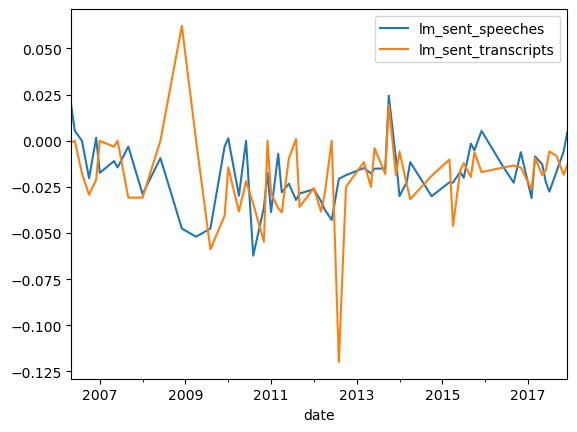

In [249]:
merged_inf = pd.merge(sinfdf, tinfdf, on='date', suffixes=['_speeches', '_transcripts'])
merged_inf.plot()
# merged_inf

<Axes: xlabel='date'>

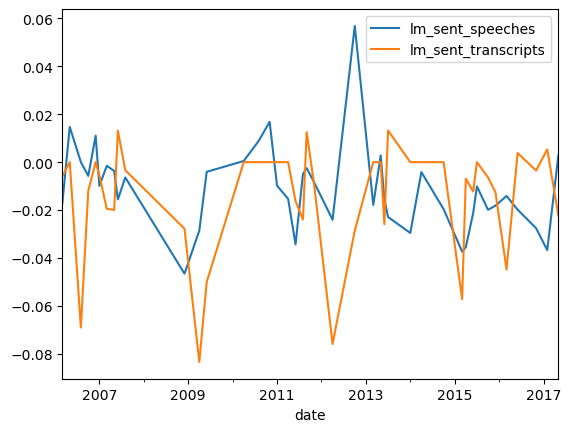

In [250]:
merged_grow = pd.merge(sgrowdf, tgrowdf, on='date', suffixes=['_speeches', '_transcripts'])
merged_grow.plot()